## Data Exploration and Preprocessing

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize, StandardScaler

In [3]:
# Load the obesity dataset and display first 10 rows
dataset = pd.read_csv('obesity_dataset.csv')
print(dataset.head(10))

    Age  Gender  Height  Weight        CALC FAVC  FCVC  NCP  SCC SMOKE  CH2O  \
0  21.0  Female    1.62    64.0          no   no   2.0  3.0   no    no   2.0   
1  21.0  Female    1.52    56.0   Sometimes   no   3.0  3.0  yes   yes   3.0   
2  23.0    Male    1.80    77.0  Frequently   no   2.0  3.0   no    no   2.0   
3  27.0    Male    1.80    87.0  Frequently   no   3.0  3.0   no    no   2.0   
4  22.0    Male    1.78    89.8   Sometimes   no   2.0  1.0   no    no   2.0   
5  29.0    Male    1.62    53.0   Sometimes  yes   2.0  3.0   no    no   2.0   
6  23.0  Female    1.50    55.0   Sometimes  yes   3.0  3.0   no    no   2.0   
7  22.0    Male    1.64    53.0   Sometimes   no   2.0  3.0   no    no   2.0   
8  24.0    Male    1.78    64.0  Frequently  yes   3.0  3.0   no    no   2.0   
9  22.0    Male    1.72    68.0          no  yes   2.0  3.0   no    no   2.0   

  family_history_with_overweight  FAF  TUE       CAEC                 MTRANS  \
0                            yes  0.0  

In [4]:
# Display the statistical summary of the dataset
print(dataset.describe())

               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75% 

In [5]:
# Count the number of missing values
missing_values = dataset.isnull().sum()
# Report any missing values in the dataset
missing_values = np.array(missing_values[missing_values > 0])
if len(missing_values) == 0:
    print("No missing values in the dataset")
else:
    print("There are missing values in the dataset")

No missing values in the dataset


In [6]:
# Apply one-hot encoding to the categorical descriptive features
X = dataset[['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP',
       'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE',
       'CAEC', 'MTRANS']]
Y = dataset['NObeyesdad']

encoder = OneHotEncoder(sparse_output=False)
enc = encoder.fit_transform(X[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC']])
df = pd.DataFrame(enc)

X = X.drop(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC'], axis=1)
df.reset_index(drop=True, inplace=True)
X = pd.concat([X, df], axis=1)


Feature Engineering

In [7]:
#Creating derived features

X['BMI'] = X['Weight'] / (X['Height'] ** 2)

In [8]:
#Categorize BMI into weight categories as per https://www.nhlbi.nih.gov/
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

X['BMI_Category'] = X['BMI'].apply(categorize_bmi)


In [9]:
#Create Activity-to-Diet Ratio
X['Activity_to_Diet_Ratio'] = X['FAF'] / (X['FCVC'] + X['NCP'] + 1)

In [10]:
#Create a Healthy Lifestyle Score
X['Healthy_Lifestyle_Score'] = X['FAF'] + X['CH2O'] - X['TUE']


In [11]:
#Normalize continuous features
scaler = StandardScaler()
continuous_features = ['Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE', 'BMI']
X[continuous_features] = scaler.fit_transform(X[continuous_features])


In [12]:
#One-hot encode BMI_Category
bmi_encoder = OneHotEncoder(sparse_output=False)
bmi_encoded = bmi_encoder.fit_transform(X[['BMI_Category']])
bmi_df = pd.DataFrame(bmi_encoded, columns=bmi_encoder.get_feature_names_out(['BMI_Category']))

#Add BMI_Category encodings and drop the original column
X = pd.concat([X, bmi_df], axis=1)
X = X.drop(['BMI_Category'], axis=1)


Indentifying strong relationships, detecting multicollinearity, and selecting features.

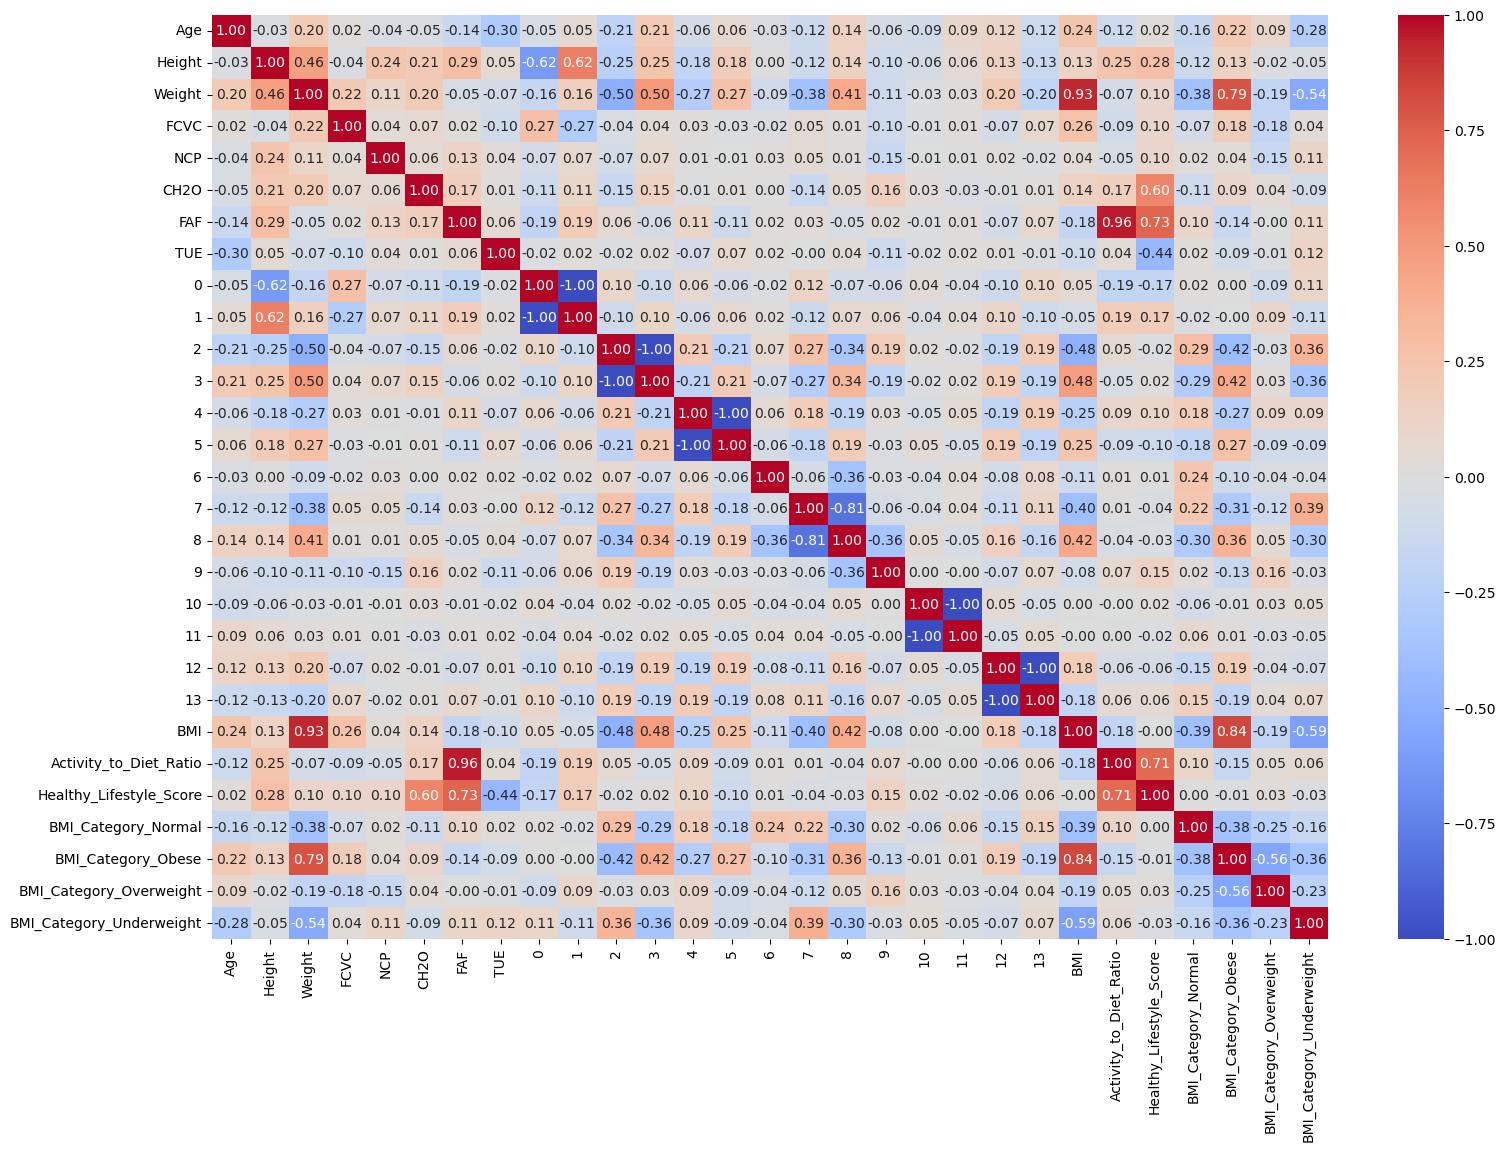

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_X = X.select_dtypes(include=[np.number])

#Compute correlation matrix
corr_matrix = numeric_X.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [ ]:
#Dropping weight and faf because they are redundant have a very high correlation with BMI and Activity_to_diet_ratio.
X = X.drop(['Weight', 'FAF'], axis=1)

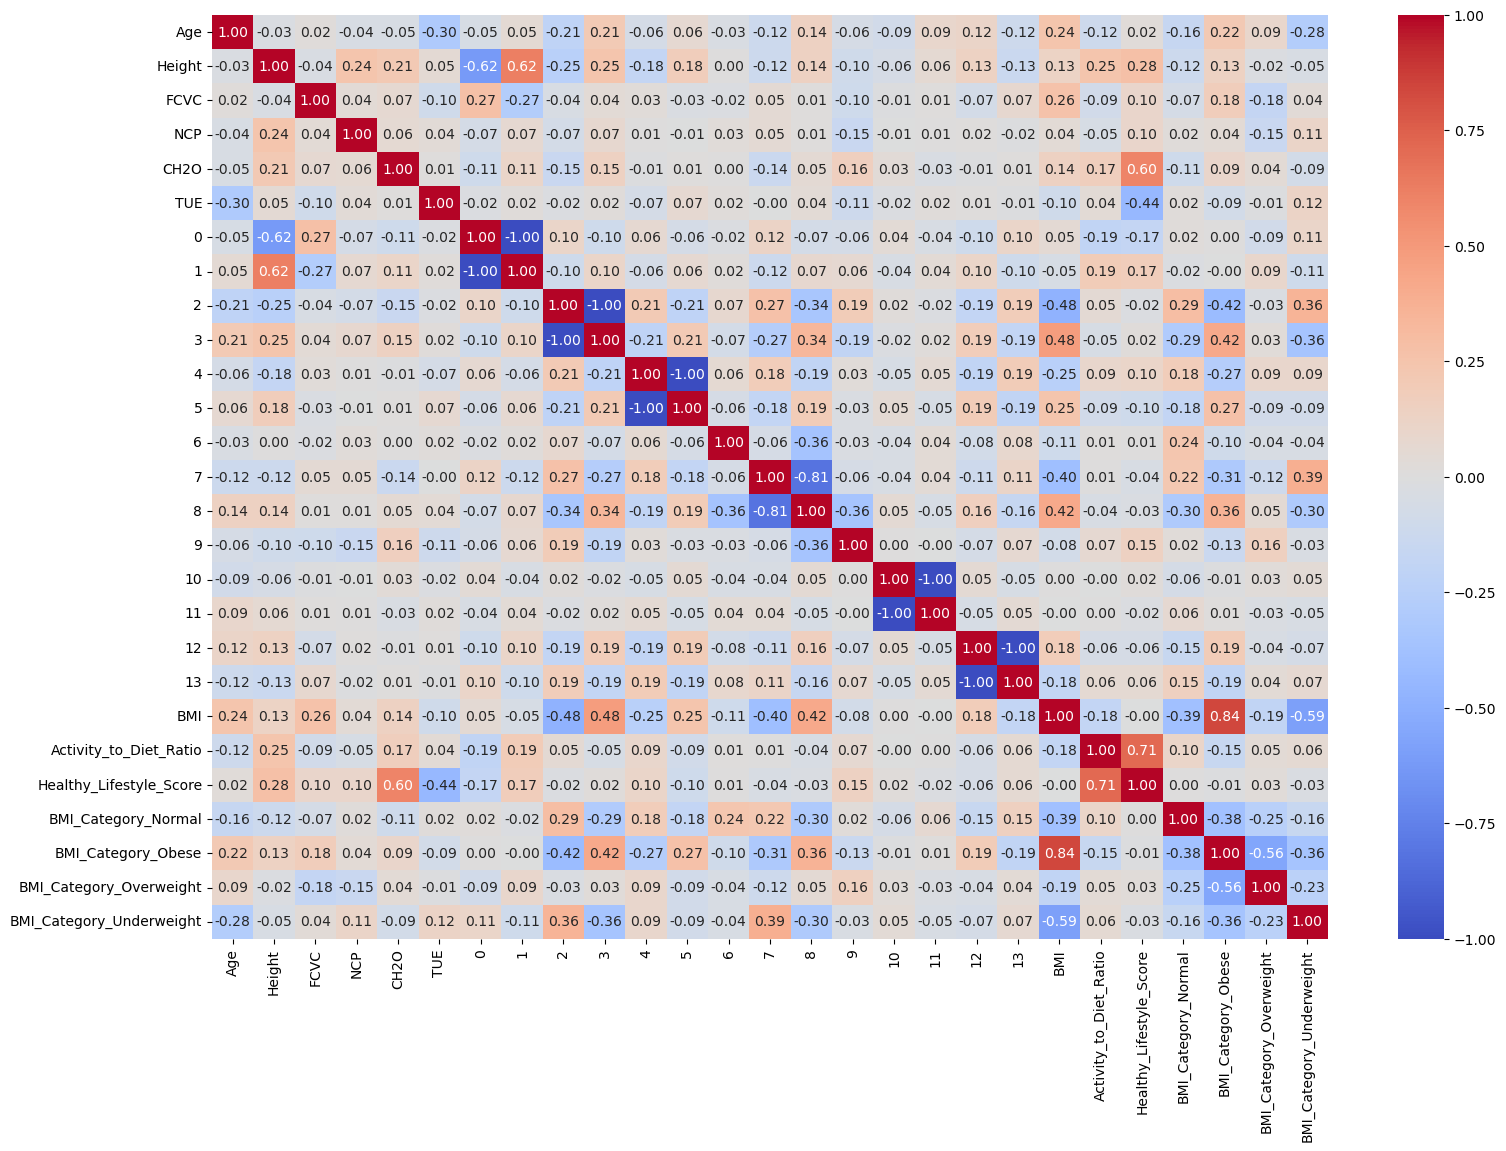

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_X = X.select_dtypes(include=[np.number])

#Compute correlation matrix
corr_matrix = numeric_X.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()